In [100]:
import pandas as pd
import numpy as np

In [101]:
import warnings
warnings.filterwarnings("ignore")

# 13  Пайплайн ML-модели

In [102]:
# Предсказание стоимости подержанных машин по их различным характеристикам.

# План решения задачи такой:

# загрузка данных и их первичный анализ
# разведочный анализ данных
# построение базовой модели (baseline)
# улучшение модели
# получение итогового предсказания и интерпретация результатов

# Used car's price prediction

# Шаг 1: загрузка и первичный анализ данных

## Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?!  
Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

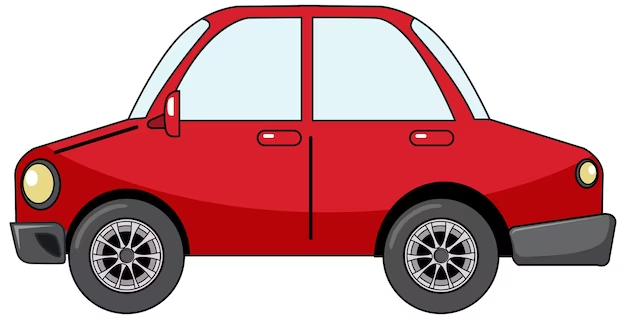

## Импорт библиотек, константы и загрузка данных

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from urllib.parse import urlencode

In [104]:
RANDOM_STATE = 42

Будем работать с данными `train.csv`.

Когда финальная модель будет готова, с помощью нее предскажем цены на машины из файла `test.csv` (там ответов нет).

In [105]:
TEST = "https://www.dropbox.com/s/asf4b1z1yme5o7u/cars_test.csv?dl=1"
TRAIN = "https://www.dropbox.com/s/qk4b79i7c078sxm/cars_train.csv?dl=1"

In [106]:
data = pd.read_csv(TRAIN)

In [107]:
data.shape

(396212, 15)

In [108]:
data.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,sellingprice
0,2013,Dodge,Dart,Limited,Sedan,automatic,1c3cdfca5dd293552,mo,4.6,13957.0,gray,black,chrysler capital,Wed Jan 21 2015 02:30:00 GMT-0800 (PST),14500
1,2014,Honda,Civic,LX,Sedan,automatic,19xfb2f56ee228781,ca,5.0,2401.0,gray,black,"ahfc/honda lease trust/hvt, inc.",Thu Feb 26 2015 04:00:00 GMT-0800 (PST),16500
2,2012,Chevrolet,Traverse,LT,suv,automatic,1gnkrged3cj244704,wi,2.4,70046.0,white,black,capital one auto finance,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT),13700


Выделим целевую переменную `sellingprice` в отдельную переменную `y`, а `X` - матрица объект-признак.

In [109]:
X = data.drop('sellingprice', axis=1)
y = data['sellingprice']

**Описание данных**

**_Признаки_**
- `year` - год производства
- `make` - производитель
- `model` - модель
- `trim` - модификация
- `body` - тип кузова
- `transmission` - тип КПП
- `vin` - идентификатор (вин)
- `state` - штат регистрации
- `condition` - состояние по шкале (1-5)
- `odometer` - пробег в милях
- `color` - цвет кузова
- `interior` - цвет интерьера
- `seller` - продавец
- `saledate` - дата продажи

**_Целевой признак_**
- `sellingprice` - стоимость продажи

In [110]:
X.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2013,Dodge,Dart,Limited,Sedan,automatic,1c3cdfca5dd293552,mo,4.6,13957.0,gray,black,chrysler capital,Wed Jan 21 2015 02:30:00 GMT-0800 (PST)
1,2014,Honda,Civic,LX,Sedan,automatic,19xfb2f56ee228781,ca,5.0,2401.0,gray,black,"ahfc/honda lease trust/hvt, inc.",Thu Feb 26 2015 04:00:00 GMT-0800 (PST)
2,2012,Chevrolet,Traverse,LT,suv,automatic,1gnkrged3cj244704,wi,2.4,70046.0,white,black,capital one auto finance,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
3,2014,Nissan,Versa Note,1.6 SV,Hatchback,automatic,3n1ce2cp9el407766,fl,2.6,23415.0,gray,black,florida auto financial group,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
4,2014,Nissan,Versa,1.6 SV,sedan,automatic,3n1cn7ap4el813308,il,3.4,17040.0,blue,black,nissan motor acceptance corporation,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT)


Посмотрим на типы колонок и число пропущенных значений в них.

In [111]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396212 entries, 0 to 396211
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          396212 non-null  int64  
 1   make          388993 non-null  object 
 2   model         388922 non-null  object 
 3   trim          388727 non-null  object 
 4   body          386883 non-null  object 
 5   transmission  350025 non-null  object 
 6   vin           396212 non-null  object 
 7   state         396212 non-null  object 
 8   condition     387759 non-null  float64
 9   odometer      396151 non-null  float64
 10  color         395679 non-null  object 
 11  interior      395679 non-null  object 
 12  seller        396212 non-null  object 
 13  saledate      396212 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 42.3+ MB


Посмотрим на числовые признаки

In [112]:
X.describe()

,year,condition,odometer
count,396212.000000,387759.000000,396151.000000
mean,2010.041442,3.425687,68336.479029
std,3.977384,0.949871,53559.280598
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28259.000000
50%,2012.000000,3.600000,52113.000000
75%,2013.000000,4.200000,99300.000000
max,2015.000000,5.000000,999999.000000


Посмотрим на категориальные признаки

In [113]:
X.describe(include='object')

,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,388993,388922,388727,386883,350025,396212,396212,395679,395679,396212,396212
unique,91,949,1899,83,2,396212,38,20,17,12530,3544
top,Ford,Altima,Base,Sedan,automatic,1c3cdfca5dd293552,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,66391,13969,39538,141921,337646,1,59164,78576,173230,14323,3783


Признак `vin` это уникальный идентификатор машины, поэтому удалим его.

In [114]:
X = X.drop('vin', axis=1)

# Разведочный анализ данных

## Заполнение пропусков

Заполним пропуски в числовых столбцах средним значением, а в категориальных - пустой категорией

In [115]:
for c in X.columns:
    if X[c].dtype == 'object':
          X[c] = X[c].fillna("")

In [116]:
for c in X.columns:
    if X[c].dtype != 'object':
          mean = np.mean(X[c])
          X[c] = X[c].fillna(mean)

## Обработка категориальных признаков - 1

Посмотрим на количество значений в каждой категории

In [117]:
for c in X.columns:
    if X[c].dtype == 'object':
          print(c, len(X[c].unique()))

make 92
model 950
trim 1900
body 84
transmission 3
state 38
color 21
interior 18
seller 12530
saledate 3544


В saledate очень много различных значений. Посмотрим почему.

In [118]:
X[['year', 'saledate']]

,year,saledate
0,2013,Wed Jan 21 2015 02:30:00 GMT-0800 (PST)
1,2014,Thu Feb 26 2015 04:00:00 GMT-0800 (PST)
2,2012,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
3,2014,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
4,2014,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT)
...,...,...
396207,2013,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
396208,2009,Mon Jun 08 2015 02:00:00 GMT-0700 (PDT)
396209,2004,Tue Jan 20 2015 02:30:00 GMT-0800 (PST)
396210,2013,Fri Dec 19 2014 11:45:00 GMT-0800 (PST)


Обработаем saledate:
* сделаем признак `car_age` - возраст машины в годах
* сделаем признак `date` - месяц + год продажи машины (категориальный)

Исходный признак `saledate` удалим

In [119]:
X['car_age'] = X['saledate'].apply(lambda x: int(x.split(" ")[3])) - X['year']
X['date'] = X['saledate'].apply(lambda x: x.split(" ")[1]+x.split(" ")[3])

X = X.drop('saledate', axis=1)

## Корреляционные матрицы

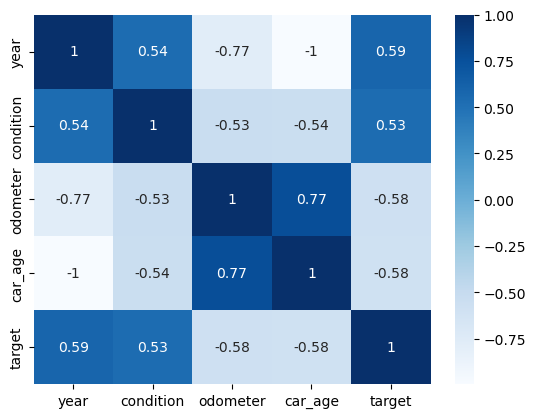

In [120]:
import seaborn as sb

X['target'] = y

cols = X.columns[X.dtypes != 'object']

corr = X[cols].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

X = X.drop('target', axis=1)

Все числовые признаки важны, запомним это

Посмотрим на аналог корреляции категориальных признаков

In [121]:
import association_metrics as am

XC = X.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

,make,model,trim,body,transmission,state,color,interior,seller,date
make,1.000000,0.942073,0.768825,0.189035,0.161258,0.080016,0.085875,0.108237,0.405386,0.059136
model,0.942073,1.000000,0.552843,0.615147,0.310298,0.120689,0.145266,0.181734,0.287182,0.086036
trim,0.768825,0.552843,1.000000,0.437450,0.291284,0.131441,0.139243,0.210486,0.267798,0.099165
body,0.189035,0.615147,0.437450,1.000000,0.171188,0.054380,0.070882,0.073898,0.251710,0.298083
transmission,0.161258,0.310298,0.291284,0.171188,1.000000,0.377115,0.063472,0.066053,0.394181,0.031898
state,0.080016,0.120689,0.131441,0.054380,0.377115,1.000000,0.064536,0.062192,0.679166,0.081021
color,0.085875,0.145266,0.139243,0.070882,0.063472,0.064536,1.000000,0.259053,0.233966,0.018536
interior,0.108237,0.181734,0.210486,0.073898,0.066053,0.062192,0.259053,1.000000,0.258849,0.061795
seller,0.405386,0.287182,0.267798,0.251710,0.394181,0.679166,0.233966,0.258849,1.000000,0.286704
date,0.059136,0.086036,0.099165,0.298083,0.031898,0.081021,0.018536,0.061795,0.286704,1.000000


Признаки make и model сильно связаны, поэтому уберем make как менее информативный

In [122]:
X = X.drop('make', axis=1)

Как посмотреть влияние категориального признака на целевую переменную? Здесь лучше всего поможет scatterplot

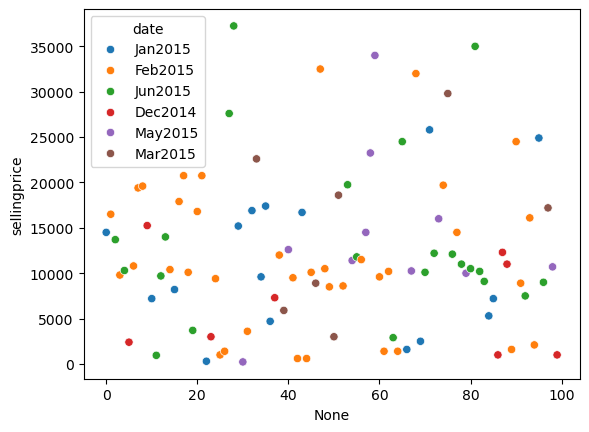

In [123]:
import seaborn as sns
 
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='date');

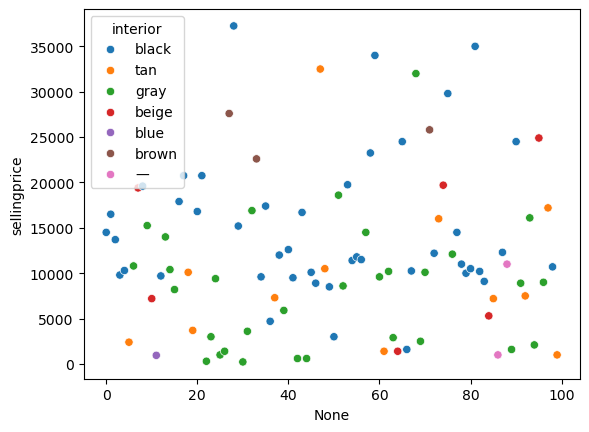

In [124]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='interior');

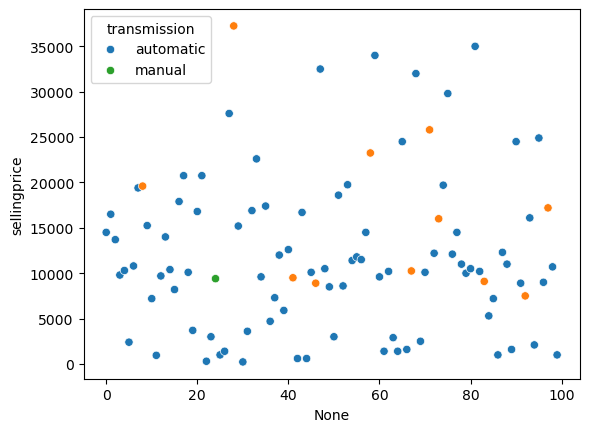

In [125]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='transmission');

Посмотрим на распределение целевой переменной

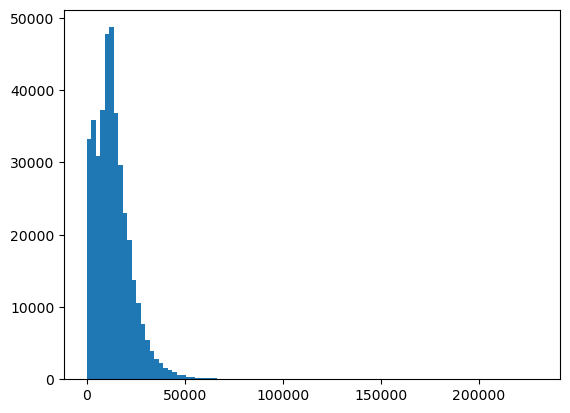

In [126]:
plt.hist(y, bins=100);

Пока мы не будем ничего делать с этим распределением, но известно, что с распределениями, отличными от нормального, большинству моделей сложно работать.

Поэтому при улучшении качества базового решения мы преобразуем это распределение.

## Поиск аномальных значений

In [127]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[X.dtypes != 'object']

year


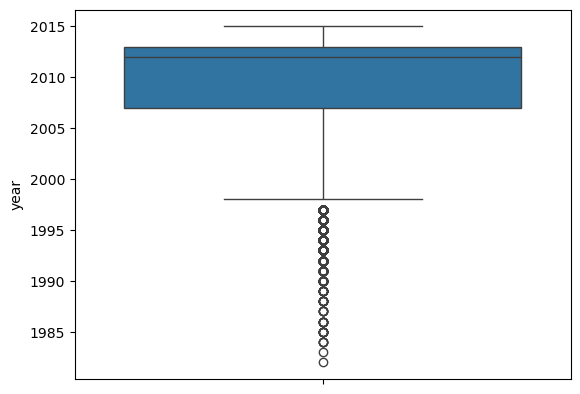

condition


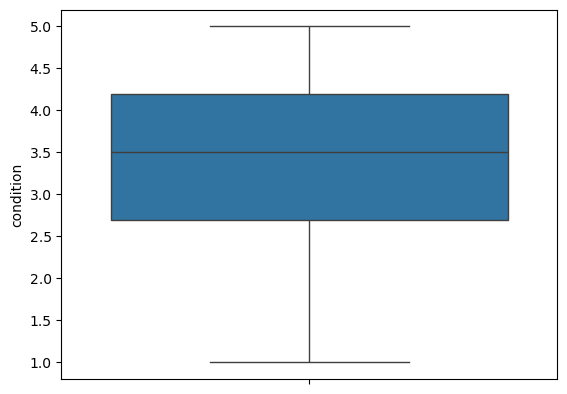

odometer


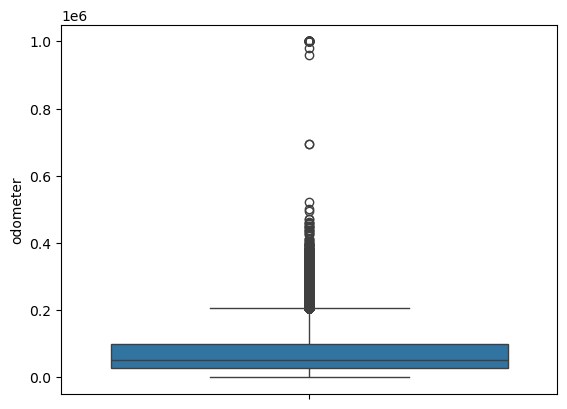

car_age


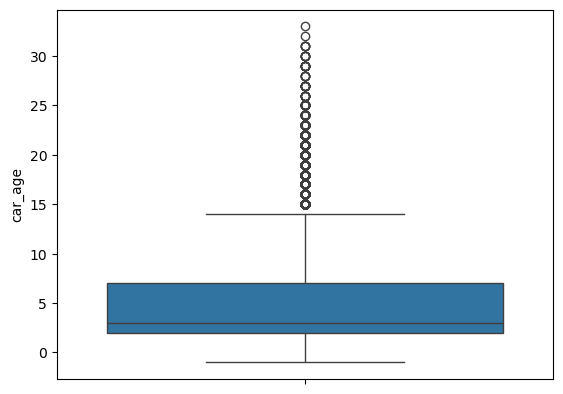

In [128]:
for col in num_cols:
    print(col)
    sb.boxplot(X[col])
    plt.show();

In [129]:
X[X['odometer'] > 800000][['car_age','odometer']]

,car_age,odometer
8651,8,999999.0
26775,8,999999.0
39643,8,999999.0
59125,8,999999.0
69969,9,999999.0
70028,10,999999.0
78649,9,999999.0
90539,14,999999.0
94884,2,999999.0
105833,8,999999.0


Выкинем машины младше 10 лет, проехавшие 1_000_000 миль - это почти точно выбросы.

In [130]:
Xnew = X[~((X.car_age < 10) & (X.odometer > 800_000))]
ynew = y[~((X.car_age < 10) & (X.odometer > 800_000))]

Xnew = Xnew.drop('car_age', axis=1)

## Построение baseline

Для baseline-модели мы сделаем следующее:
* закодируем категориальные признаки при помощи TargetEncoder
* масштабируем все признаки с помощью StandardScaler
* обучим линейную регрессию

In [131]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

Разобъем данные на тренировочную и тестовую части

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, test_size=0.25, random_state=42)

Осуществим задуманные шаги

In [133]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


enc = TargetEncoder(cols=cat_cols)

enc.fit(X_train, y_train)
X_train_new = enc.transform(X_train)
X_test_new = enc.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new = pd.DataFrame(scaler.transform(X_train_new), columns=X_train.columns)
X_test_new = pd.DataFrame(scaler.transform(X_test_new), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_new, y_train)
pred = model.predict(X_test_new)

Оценим качество полученной модели

In [134]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

MAPE(y_test, pred)

0.7151865211267145

Ошибка в среднем 71% от цены - модель пока не очень хорошая, есть куда улучшать!

## Pipeline

In [135]:
from sklearn.pipeline import Pipeline

p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

In [136]:
p1.fit(X_train, y_train)

Pipeline(steps=[('encoder_',
                 TargetEncoder(cols=Index(['model', 'trim', 'body', 'transmission', 'state', 'color', 'interior',
       'seller', 'date'],
      dtype='object'))),
                ('scaler_', StandardScaler()), ('model_', LinearRegression())])

In [137]:
pred = p1.predict(X_test)

MAPE(y_test, pred)

0.7151865211267145

## Первые улучшения

В нашем пайплайне три шага:
* закодируем категориальные признаки при помощи TargetEncoder
* масштабируем все признаки с помощью StandardScaler
* обучим линейную регрессию

Как можно улучшить решение?

1) Можно подобрать гиперпараметры кодировщика в шаге 1, а также сам кодировщик

2) Можно использовать другой способ масштабирования данных

3) Можно использовать другую модель!

In [138]:
from sklearn.preprocessing import MinMaxScaler

# по умолчанию smoothing = 10 (сглаживание)

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p7 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p8 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

In [139]:
for i, p in enumerate([p1,p2,p3,p4,p5,p6,p7,p8]):
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    print(i + 1, MAPE(y_test, pred))

1 0.7151865211267145
2 0.7207471981890006
3 0.7246917683308541
4 0.7207471981889991
5 0.7151865211267121
6 0.7246917683308525
7 0.7217788610751903
8 0.7217788610751872


Значительных улучшений нет.

Сменим теперь модель!

In [140]:
p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p9.fit(X_train, y_train)
pred = p9.predict(X_test)
pred_p9 = MAPE(y_test, pred)
pred_p9

0.21300201388079582

Уже гораздо лучше. Попробуем для RandomForest поменять кодировщик, его гиперпараметры и скалер.

In [141]:
from sklearn.preprocessing import MinMaxScaler

p10 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p11 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p12 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p13 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

In [142]:
for i,p in enumerate([p9,p10,p11,p12,p13]):
    p.fit(X_train.iloc[:50000], y_train[:50000])
    pred = p.predict(X_test)
    print(i+9, MAPE(y_test, pred))

9 0.3321349410680927
10 1.951828715663988
11 0.343079138395571
12 1.9497228597922787
13 0.3195281831571252


Посмотрим на важность признаков

In [143]:
weights = pd.DataFrame({'Features': X_train.columns, 'Scores': p9['model_'].feature_importances_}).sort_values('Scores', ascending=False).reset_index(drop=True)
weights

,Features,Scores
0,model,0.371062
1,odometer,0.356048
2,year,0.082919
3,trim,0.062164
4,seller,0.054742
5,body,0.022826
6,condition,0.021292
7,state,0.008124
8,color,0.006576
9,interior,0.006284


## Попытки улучшить модель

### Шаг 1

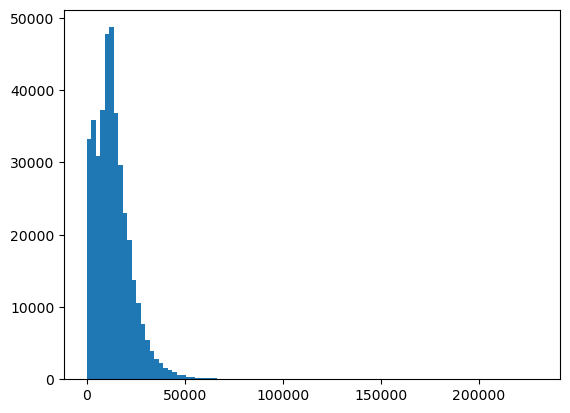

In [144]:
plt.hist(y, bins=100);

Попробуем сделать распределение целевой переменной более похожим на нормальное и заново обучить лучшую модель с предыдущего шага.

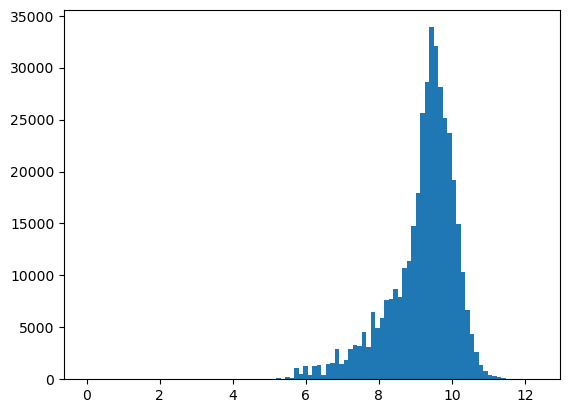

In [145]:
plt.hist(np.log(y), bins=100);

In [146]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [147]:
p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p9.fit(X_train, y_train)
pred = p9.predict(X_test)

MAPE(np.exp(y_test), np.exp(pred))

0.1885688407823995

Качество модели возросло!

### Шаг 2

Подберем оптимальные параметры леса при помощи Optuna

In [148]:
data_pipeline = Pipeline([
        ('encoder_',TargetEncoder(cols=cat_cols)),
        ('scaler_', StandardScaler())
])

X_train_good = data_pipeline.fit_transform(X_train, y_train)
X_test_good = data_pipeline.transform(X_test)

In [149]:
import optuna

def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None])
    }

    estimator = RandomForestRegressor(**param, verbose=False, n_jobs=-1)

    estimator.fit(X_train_good[:50000], y_train.iloc[:50000])
    pred = estimator.predict(X_test_good)

    return MAPE(np.exp(y_test), np.exp(pred))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2025-05-02 17:05:01,050] A new study created in memory with name: no-name-cf15d2fe-af22-4321-a78c-358c0779a151
[I 2025-05-02 17:05:41,721] Trial 0 finished with value: 0.22121105272712066 and parameters: {'n_estimators': 648, 'max_features': None}. Best is trial 0 with value: 0.22121105272712066.
[I 2025-05-02 17:05:49,458] Trial 1 finished with value: 0.23530926152376097 and parameters: {'n_estimators': 294, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.22121105272712066.
[I 2025-05-02 17:06:00,951] Trial 2 finished with value: 0.23208537532086548 and parameters: {'n_estimators': 406, 'max_features': 'log2'}. Best is trial 0 with value: 0.22121105272712066.
[I 2025-05-02 17:06:03,624] Trial 3 finished with value: 0.2312930035438829 and parameters: {'n_estimators': 99, 'max_features': 'log2'}. Best is trial 0 with value: 0.22121105272712066.
[I 2025-05-02 17:06:38,290] Trial 4 finished with value: 0.2241251117133714 and parameters: {'n_estimators': 480, 'max_features': None

FrozenTrial(number=0, state=1, values=[0.22121105272712066], datetime_start=datetime.datetime(2025, 5, 2, 17, 5, 1, 50132), datetime_complete=datetime.datetime(2025, 5, 2, 17, 5, 41, 721234), params={'n_estimators': 648, 'max_features': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None))}, trial_id=0, value=None)


In [150]:
model = RandomForestRegressor(n_estimators=27, n_jobs=-1)

model.fit(X_train_good, y_train)
pred = model.predict(X_test_good)
MAPE(np.exp(y_test), np.exp(pred))

0.18794937462201733

## Улучшаем модель дальше

Лучшая модель с предыдущего шага - RandomForest (MAPE = 0.178)

Попробуем CatBoost!

In [151]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()

model.fit(X_train_good, y_train)
pred = model.predict(X_test_good)

MAPE(np.exp(y_test), np.exp(pred))

Learning rate set to 0.100672
0:	learn: 0.8540169	total: 202ms	remaining: 3m 21s
1:	learn: 0.7942785	total: 221ms	remaining: 1m 50s
2:	learn: 0.7401870	total: 240ms	remaining: 1m 19s
3:	learn: 0.6927492	total: 258ms	remaining: 1m 4s
4:	learn: 0.6506373	total: 276ms	remaining: 54.9s
5:	learn: 0.6140237	total: 293ms	remaining: 48.5s
6:	learn: 0.5820326	total: 311ms	remaining: 44.1s
7:	learn: 0.5527775	total: 331ms	remaining: 41.1s
8:	learn: 0.5273501	total: 349ms	remaining: 38.4s
9:	learn: 0.5046264	total: 367ms	remaining: 36.3s
10:	learn: 0.4849635	total: 386ms	remaining: 34.7s
11:	learn: 0.4673753	total: 406ms	remaining: 33.5s
12:	learn: 0.4520332	total: 425ms	remaining: 32.3s
13:	learn: 0.4387389	total: 444ms	remaining: 31.2s
14:	learn: 0.4273062	total: 462ms	remaining: 30.3s
15:	learn: 0.4168758	total: 481ms	remaining: 29.6s
16:	learn: 0.4077701	total: 501ms	remaining: 29s
17:	learn: 0.3999513	total: 519ms	remaining: 28.3s
18:	learn: 0.3928886	total: 539ms	remaining: 27.8s
19:	learn:

0.18851937358986648

Подберем гиперпараметры catboost

In [152]:
import optuna

def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
    }

    estimator = CatBoostRegressor(**param, verbose=False)

    estimator.fit(X_train_good[:50000], y_train.iloc[:50000])
    pred = estimator.predict(X_test_good)

    return MAPE(np.exp(y_test), np.exp(pred))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2025-05-02 17:13:05,020] A new study created in memory with name: no-name-91850a8e-dd28-49fa-9ec1-4d7e293c7b9e
[I 2025-05-02 17:20:30,105] Trial 0 finished with value: 0.21717883397573634 and parameters: {'n_estimators': 955, 'max_depth': 15}. Best is trial 0 with value: 0.21717883397573634.
[I 2025-05-02 17:20:33,724] Trial 1 finished with value: 0.20071531666306297 and parameters: {'n_estimators': 682, 'max_depth': 7}. Best is trial 1 with value: 0.20071531666306297.
[I 2025-05-02 17:20:34,310] Trial 2 finished with value: 0.22906608259007127 and parameters: {'n_estimators': 143, 'max_depth': 4}. Best is trial 1 with value: 0.20071531666306297.
[I 2025-05-02 17:20:39,113] Trial 3 finished with value: 0.19438707633711363 and parameters: {'n_estimators': 718, 'max_depth': 8}. Best is trial 3 with value: 0.19438707633711363.
[I 2025-05-02 17:20:41,770] Trial 4 finished with value: 0.2035285492624369 and parameters: {'n_estimators': 644, 'max_depth': 6}. Best is trial 3 with value: 0.

FrozenTrial(number=12, state=1, values=[0.19131725861580934], datetime_start=datetime.datetime(2025, 5, 2, 17, 25, 38, 226794), datetime_complete=datetime.datetime(2025, 5, 2, 17, 26, 5, 486133), params={'n_estimators': 767, 'max_depth': 11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=12, value=None)


In [153]:
model = CatBoostRegressor(n_estimators=477, max_depth=11)

model.fit(X_train_good, y_train)
pred_cb = model.predict(X_test_good)

MAPE(np.exp(y_test), np.exp(pred_cb))

Learning rate set to 0.183769
0:	learn: 0.7899825	total: 75.5ms	remaining: 35.9s
1:	learn: 0.6832326	total: 150ms	remaining: 35.5s
2:	learn: 0.5997472	total: 216ms	remaining: 34.2s
3:	learn: 0.5350876	total: 283ms	remaining: 33.5s
4:	learn: 0.4845264	total: 343ms	remaining: 32.4s
5:	learn: 0.4453096	total: 412ms	remaining: 32.3s
6:	learn: 0.4162230	total: 485ms	remaining: 32.5s
7:	learn: 0.3936800	total: 548ms	remaining: 32.2s
8:	learn: 0.3766028	total: 613ms	remaining: 31.9s
9:	learn: 0.3630786	total: 683ms	remaining: 31.9s
10:	learn: 0.3533589	total: 751ms	remaining: 31.8s
11:	learn: 0.3446474	total: 814ms	remaining: 31.6s
12:	learn: 0.3376677	total: 881ms	remaining: 31.4s
13:	learn: 0.3322356	total: 941ms	remaining: 31.1s
14:	learn: 0.3277302	total: 998ms	remaining: 30.7s
15:	learn: 0.3244077	total: 1.05s	remaining: 30.4s
16:	learn: 0.3217219	total: 1.11s	remaining: 30s
17:	learn: 0.3194727	total: 1.17s	remaining: 29.8s
18:	learn: 0.3173098	total: 1.23s	remaining: 29.6s
19:	learn: 0

0.17039958909106245

Теперь пусть CatBoost сам кодирует признаки!

In [154]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297137 entries, 82213 to 121967
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          297137 non-null  int64  
 1   model         297137 non-null  object 
 2   trim          297137 non-null  object 
 3   body          297137 non-null  object 
 4   transmission  297137 non-null  object 
 5   state         297137 non-null  object 
 6   condition     297137 non-null  float64
 7   odometer      297137 non-null  float64
 8   color         297137 non-null  object 
 9   interior      297137 non-null  object 
 10  seller        297137 non-null  object 
 11  date          297137 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 29.5+ MB


In [155]:
cat_features = [1,2,3,4,5,8,9,10,11]

In [156]:
model = CatBoostRegressor(cat_features=cat_features)

model.fit(X_train, y_train)
pred = model.predict(X_test)

MAPE(np.exp(y_test), np.exp(pred))

Learning rate set to 0.100672
0:	learn: 0.8565483	total: 213ms	remaining: 3m 32s
1:	learn: 0.7972888	total: 436ms	remaining: 3m 37s
2:	learn: 0.7441473	total: 653ms	remaining: 3m 36s
3:	learn: 0.6957480	total: 847ms	remaining: 3m 30s
4:	learn: 0.6514757	total: 1.03s	remaining: 3m 25s
5:	learn: 0.6130233	total: 1.24s	remaining: 3m 25s
6:	learn: 0.5801864	total: 1.41s	remaining: 3m 20s
7:	learn: 0.5511075	total: 1.61s	remaining: 3m 20s
8:	learn: 0.5213029	total: 1.86s	remaining: 3m 25s
9:	learn: 0.4985436	total: 2.05s	remaining: 3m 22s
10:	learn: 0.4777652	total: 2.2s	remaining: 3m 18s
11:	learn: 0.4605210	total: 2.37s	remaining: 3m 15s
12:	learn: 0.4422734	total: 2.62s	remaining: 3m 19s
13:	learn: 0.4275537	total: 2.83s	remaining: 3m 19s
14:	learn: 0.4156051	total: 3.09s	remaining: 3m 22s
15:	learn: 0.4032171	total: 3.29s	remaining: 3m 22s
16:	learn: 0.3946539	total: 3.48s	remaining: 3m 21s
17:	learn: 0.3870855	total: 3.67s	remaining: 3m 20s
18:	learn: 0.3799812	total: 3.88s	remaining: 

0.1766529865352466

## Stacking и Blending

### Простое смешивание

* RandomForest - 0.178
* CatBoost - 0.170

In [157]:
pred_final = 0.3 * pred_p9 + 0.7 * pred_cb

MAPE(np.exp(y_test), np.exp(pred_final))

0.9291094642098809

### Stacking (и blending)


In [158]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('cb', CatBoostRegressor(n_estimators=477, max_depth=11))
    ]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))

In [159]:
reg.fit(X_train_good, y_train)
pred_stacking = reg.predict(X_test_good)

MAPE(np.exp(y_test), np.exp(pred_stacking))

Learning rate set to 0.183769
0:	learn: 0.7899825	total: 57ms	remaining: 27.2s
1:	learn: 0.6832326	total: 114ms	remaining: 27s
2:	learn: 0.5997472	total: 171ms	remaining: 27s
3:	learn: 0.5350876	total: 232ms	remaining: 27.4s
4:	learn: 0.4845264	total: 301ms	remaining: 28.4s
5:	learn: 0.4453096	total: 364ms	remaining: 28.6s
6:	learn: 0.4162230	total: 421ms	remaining: 28.3s
7:	learn: 0.3936800	total: 481ms	remaining: 28.2s
8:	learn: 0.3766028	total: 535ms	remaining: 27.8s
9:	learn: 0.3630786	total: 591ms	remaining: 27.6s
10:	learn: 0.3533589	total: 646ms	remaining: 27.4s
11:	learn: 0.3446474	total: 705ms	remaining: 27.3s
12:	learn: 0.3376677	total: 763ms	remaining: 27.2s
13:	learn: 0.3322356	total: 820ms	remaining: 27.1s
14:	learn: 0.3277302	total: 878ms	remaining: 27s
15:	learn: 0.3244077	total: 934ms	remaining: 26.9s
16:	learn: 0.3217219	total: 992ms	remaining: 26.9s
17:	learn: 0.3194727	total: 1.05s	remaining: 26.7s
18:	learn: 0.3173098	total: 1.1s	remaining: 26.6s
19:	learn: 0.315490

0.19038132152325252

## Сохранение результатов

Что сохраняем?

* Предсказания моделей
* Модели

In [ ]:
test_data = pd.read_csv("https://www.dropbox.com/s/asf4b1z1yme5o7u/cars_test.csv?dl=1")

test_data.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2011,Chevrolet,HHR,LT,Wagon,automatic,3gnbabfwxbs592572,ny,2.5,99177.0,silver,gray,credit acceptance corp/vrs/southfield,Thu Feb 26 2015 01:15:00 GMT-0800 (PST)
1,2008,Ford,Econoline Cargo,E-150,Van,automatic,1ftne14w28db27123,mn,2.8,131850.0,white,gray,ari,Thu Jan 22 2015 02:45:00 GMT-0800 (PST)
2,2013,Chrysler,200,Touring,Sedan,automatic,1c3ccbbbxdn678363,tn,3.9,43643.0,—,gray,enterprise veh exchange/rental,Wed Feb 25 2015 02:30:00 GMT-0800 (PST)
3,2013,Hyundai,Elantra,GLS,Sedan,automatic,5npdh4ae7dh257662,la,3.2,59294.0,white,beige,the hertz corporation,Wed Dec 31 2014 10:00:00 GMT-0800 (PST)
4,2012,Ford,Explorer,Limited,SUV,automatic,1fmhk8f83cga78501,nj,2.5,39311.0,gray,black,"ford motor credit company,llc",Wed Feb 04 2015 01:00:00 GMT-0800 (PST)


Заполняем пропуски

In [163]:
for c in test_data.columns:
    if test_data[c].dtype == 'object':
          test_data[c] = test_data[c].fillna("")

In [164]:
for c in test_data.columns:
    if test_data[c].dtype != 'object':
          mean = np.mean(X[c])
          test_data[c] = test_data[c].fillna(mean)

Обрабатываем дату

In [165]:
test_data['date'] = test_data['saledate'].apply(lambda x: x.split(" ")[1] + x.split(" ")[3])

Удаляем столбцы

In [166]:
test_data = test_data.drop(['vin','make','saledate'], axis=1)

Преобразуем данные перед применением модели

In [170]:
test_good = data_pipeline.transform(test_data)

Применяем модель

In [171]:
# test_pred = model.predict(test_good)

Сохраняем предсказания в файл

In [172]:
# test_data['prediction'] = test_pred

# test_data[['prediction']].to_csv("test_prediction.csv", index=False)

### Сохраним модель

In [ ]:
# import pickle

# with open('model.pickle', 'wb') as f:
#     pickle.dump(model, f)

# # а так модель можно загрузить из файла:
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)